# Introduction to the Titanic Dataset

This is a notebook that explores the titanic dataset in its entirety, it uses machine learning to create a model that predicts which passengers survived the Titanic shipwreck. It covers an array of data science concepts including exploratory data analysis (EDA), data preprocessing techniques, feature engineering and modelling. The goal of this notebook is to provide easy to consume data science knowledge for beginners.

Let's begin by getting acquainted with the raw data features. All of the following information can be found under the titanic competition's data section.

*  `Embarked:` is the port where they embarked
   *  C = Cherbourg
   *  Q = Queenstown
   *  S = Southampton
*  `Pclass`: A proxy for socio-economic status (SES)
   *  1st = Upper 
   *  2nd = Middle
   *  3rd = Lower 
*  `Sex:` Male or Female
*  `Name:` Name of passenger
*  `Age:` Age in years, fractional if less than 1. If the age is estimated, is it in the form of xx.5
*  `SibSp:` Number of siblings/spouses aboard the titanic. The dataset defines family relations in this way... 
   *  Sibling = brother, sister, stepbrother, stepsister
   *  Spouse = husband, wife (mistresses and fiancés were ignored)
*  `Parch:` Number of parents/children aboard the titanic, the dataset defines family relations in this way... 
   *  Parent = mother, father
   *  Child = daughter, son, stepdaughter, stepson <br>
   *  Some children travelled only with a nanny, therefore parch=0 for them.<br>
*  `Fare:` is the passenger fare	
*  `Ticket:` is the ticket number of the passenger 
*  `PassengerID:` is the unique id of the row 
*  `Cabin:` is the cabin number of the passenger

The corresponding target is..

*  **`Survived:`** 
   *  1 = yes
   *  0 = no

# Setup
Import everything necessary for the notebook - titanic dataset and data science libraries.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


#Libraries used for preprocessing data/exploratory data analysis
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns

#Importing models used in the notebook
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm 

#Importing objects to help tune hyperparameters and create train/validation split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

#Importing objects used for cross-validation
from sklearn.model_selection import StratifiedKFold

#Importing metrics used to analyze model performance
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, plot_roc_curve, roc_auc_score

#Importing libraries used for feature importance 
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots

#Load the data
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
all_data = pd.concat([train_data, test_data], axis = 0)


sns.set()  #Setting the style of plots to seaborns default style
%matplotlib inline  #Plots will automatically show

C:\AnacondaPython\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\AnacondaPython\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
UsageError: unrecognized arguments: #Plots will automatically show


# 1 - Exploratory Data Analysis
This section provides provides an overview of the data and explains how the data imbalance will be dealt with. Also, it provides a more detailed analysis of the target and features. If you already have an understanding of the dataset skip to section 2 - Feature Engineering.

## 1.1 - Overview

In [ ]:
print(train_data.info())
train_data.head(5)

In [ ]:
test_data.info()

**Comments:**
* The training set has missing data from the following columns - `Age`, `Cabin` and `Embarked`.
* The test set has missing data from the following columns - `Age`, `Cabin` and `Fare`.
* The shape of the training set and test are (891, 12) and  (418, 11) respectively. 
  * This means the training set consist of 891 samples, 11 predictors and the target. The test set consists of 418 samples and 11 predictors which are used to predict corresponding targets that are submitted to kaggle. 
  *  This means that the training set accounts for 68% of the population data.

In [ ]:
all_data.describe(include = 'all') #include is used to include categorical variables such as Sex

**Observations:**
* **The dataset is imbalanced** - more passengers did not survive the accident than those who did. The only possible values are 1 and 0 - the mean is 0.38.
* `Pclass` shows there were more 'lower class' passengers than 'upper class' passengers aboard the titanic - observable by the mean.
* `Sex` shows that there were more males than females aboard the titanic. 
* The interquartile range of `Age` shows the passengers are between the ages 21 - 39 and the average age of a passenger is ~30 years old.
* `SibSp` and `Parch` at the 50th percentile are 0, this means 50% of the people aboard the titanic came with no family.
* `Fare` is skewed heavily to the right. The average price of a ticket is higher than the 75th quantile. 
* `Embarked` shows that the majority of the titanics occupants embarked from South Hampton.

In [ ]:
#Table showing correlation values amongst features.
train_data.corr()

In [ ]:
#Heatmap of the correlated table - useful for when there are lots of features - easier to read.
plt.figure(figsize=(8,8))
sns.heatmap(train_data.corr(), cmap = 'viridis', annot = True, square = True, lw=1, linecolor='black')

**Observations:**
* The most significantly correlated feature to `Survived` is `Pclass` at a negative correlation of -0.34.
* As expected, `Fare` is negatively correlated with `Pclass` at -0.55. 

The overview has provided some good observations but it is always a good idea to investigate each feature and it's distribution with the target. By doing this, perhaps some relationships can be discovered between the features and the target. Also, it provides one with the opportunity to see if there is any preprocessing/feature engineering that can be performed.


## 1.2 - Data Imbalance
It's already been seen that the dataset is imbalanced, this section aims to cover issues that arise from it and how they can be dealt with.

In [ ]:
#Percentage of survivors
total_pass = 100 * train_data[train_data['Survived'] == 0]['Survived'].count()/train_data['Survived'].count() #% of Passed 
total_surv = (100 - total_pass) #Percentage of survivors
print(f"% of passengers who passed: {total_pass.round(2)}% \n% of passengers who survived: {total_surv.round(2)}%")

#Plotting Number of survivors
sns.countplot(x = 'Survived', data = train_data)

**Comments about imbalance:**
* The people who survived are considered a minority class while those who did not survive are the majority class. Most datasets in the real world are imbalanced, similar to the titanic dataset. In such cases, the machine learning algorithms used for classification will not be optimized. This is because they are designed to learn around an equal number of samples for each class.
* Another problem that can arise with an imbalanced dataset is that it can fool one into believing they created a "good" model. For example, imagine a binary classification problem similar to the titanic dataset where the targets are SO imbalanced such that the majority class accounts for 90% of the target while the minority class accounts for only 10% of the targets. This means that if you produce a model that ALWAYS guesses the majority class it will be accurate 90% of the time, however anyone could make this predicition which makes the model useless.
* There are a few possible solutions to tackle this problem of imbalanced data...
  * Selecting performance metrics, such as those that focus on the minority class.
  * Implementing data preparation methods, such as those that attempt to re-balance the classes (Upsampling & Downsampling)

The technique that is implemented in this notebook is the prior - focusing on metrics that focus on the minority class.


## 1.3 - Categorical Features
There are seven categorical features in the dataset - `Ticket`, `Embarked`, `Cabin`, `PassengerID`, `Pclass`, `Sex` and `Names`.

However some of the features will not be useful for the model and will therefore be dropped. These are the reasons why they will not be included.
* `PassengerID` is arbitrarily chosen and therefore will not be valuable to the model.
* `Cabin` has a large amount of data missing, the training set is missing 687 entries and the test set is missing 327 entries. Some of this information can be found from researching the titanic online, cabins/decks where passengers stayed are based on their socioeconomic class and fare. However, some decks had a mix of passengers from first/second class and second/third class, it would take too long to research this and fill the data manually. The other option is to assign decks/cabins to passengers based on their socioeconomic class until each deck hits its capacity. But there would be no way to gaurantee that the passenger belonged in that deck (unless we go through the data manually) and the model may pickup on an inaccurate trend based on this. 
* `Ticket` has 681 unique entries, this means some passengers share the same ticket number. If passengers share the same ticket number they likely travelled together and stayed in the same cabin/deck. However, passengers that travelled in groups are likely caught by the features `SibSp` and `Parch`. There may be some passengers who travelled together that are not family - however introducing a grouping based off ticket number will introduce repititive information to the model (from the groups of families). Any other information contained in `Ticket` would likely be captured by the other features. i.e.: Prefix for ticket could represent the port the passenger departed from.

Let's focus on the target distribution in the categorical features that will be included in the model - `Sex`, `Embarked`, `Pclass` and `Name`

**NOTE:**  
* There are 17 unique titles that can be extracted from the feature `Name`. Feature engineering on `Name` will be covered in section 2.

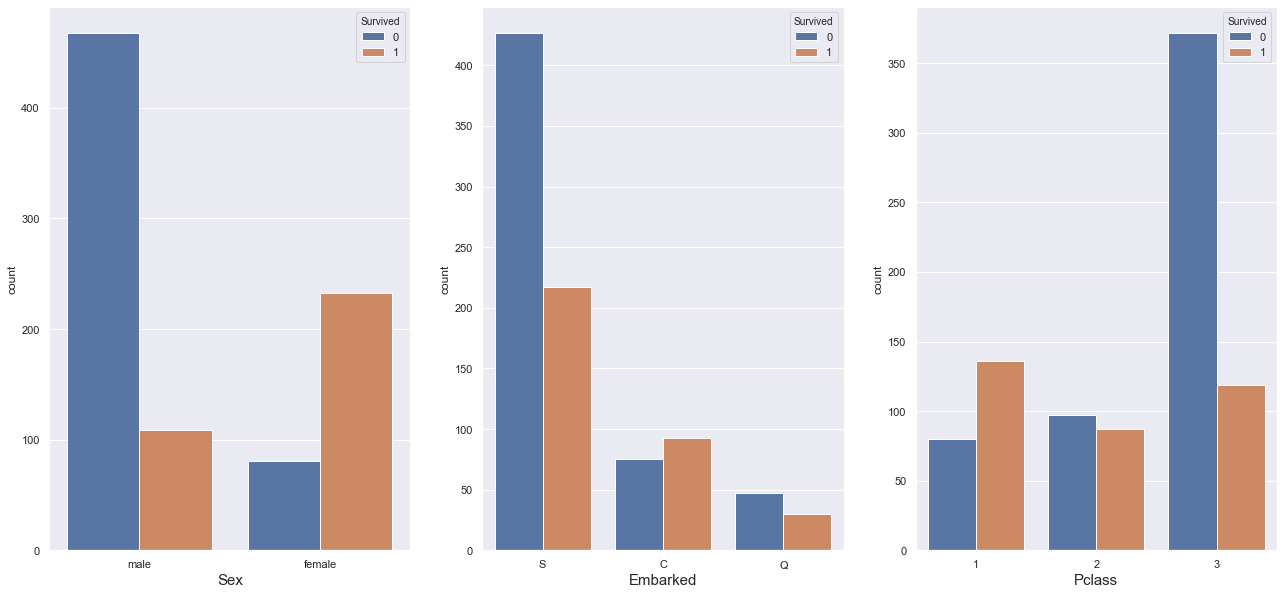

In [2]:
#Creating the axes for the plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,10))

#Plotting the target distribution of the categorical features - excluding Name and Ticket 
#Feature engineering for these are covered in section 2
sns.countplot(x='Sex', data=train_data, hue = 'Survived', ax=axes[0])
axes[0].set_xlabel('Sex', fontsize=15)
sns.countplot(x='Embarked', data=train_data, hue='Survived', ax=axes[1])
axes[1].set_xlabel('Embarked', fontsize=15)
sns.countplot(x='Pclass', data=train_data, hue='Survived', ax=axes[2])
axes[2].set_xlabel('Pclass', fontsize=15)

#Storing PassengerID for later use in submission CSV file
test_PassengerID = test_data['PassengerId']

#Dropping PassengerID and Name because they will no longer be used.
#Cabin and Ticket help in understanding missing data in section 3 and will therefore not be dropped yet.
train_data.drop(['PassengerId'], axis=1, inplace=True)
test_data.drop(['PassengerId'], axis=1, inplace=True)

**Target Dist. in Categ. Features - Observations**
* There were approximately twice as many males aboard the titanic as there were females but the survival rates varied dramatically between the sexes.
  * Approximately 1/5 of all male passengers survived
  * Approximately 3/4 of all female passengers survived.
* The survival rate decreases for each step down in socioeconomic class. 
  * There are considerably more 3rd class passengers than 1st and 2nd class passengers.
* The majority of passengers left from South Hampton and they have the lowest survival rate.
  * Fact: 50% of the people who boarded at South Hampton were third class passengers.
  
## 1.4 - Numerical Features
There are four numeric features being considered - `Age`, `Fare`, `Parch` and `SibSp`. 

Let's begin by examining the target distribution in the four features. It's known `Fare` is heavily skewed by expensive tickets. To get a better visual of the distribution the top 5% of the most expensive tickets will be dropped.

Text(0.5, 0, 'Parch Dist.')

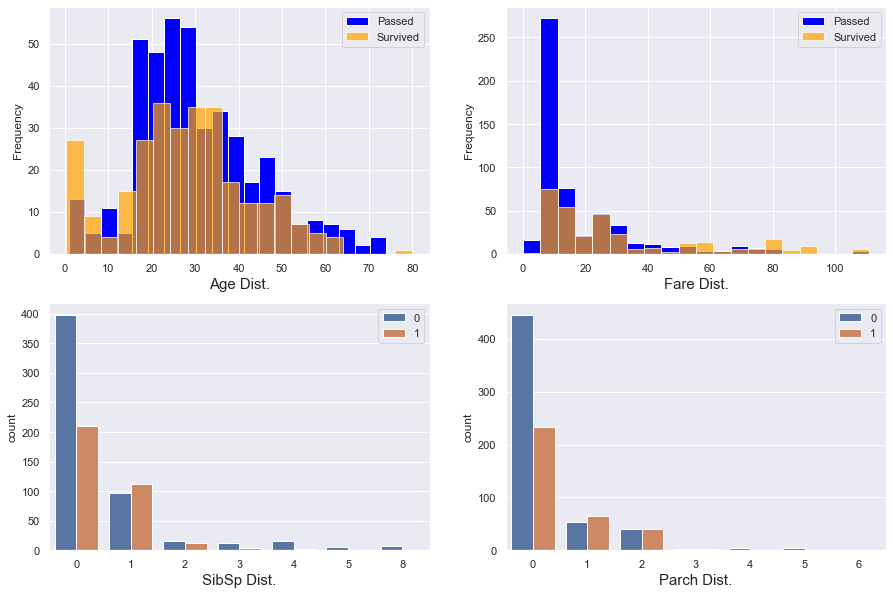

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

#Plotting the feature Age
train_data[train_data['Survived'] == 0]['Age'].plot(kind = 'hist', bins = 20, color = 'blue', label = 'Passed', ax = axes[0][0])
train_data[train_data['Survived'] == 1]['Age'].plot(kind = 'hist', bins = 20, color = 'orange', alpha = 0.7, label = 'Survived', ax = axes[0][0])
axes[0][0].legend()
axes[0][0].set_xlabel('Age Dist.', fontsize=15)

#Defining the 95th quantile of ticket prices & plotting the feature Fare
quant_95 = np.quantile(train_data['Fare'], 0.95)
train_data[(train_data['Survived']==0)&(train_data['Fare']<quant_95)]['Fare'].plot(kind = 'hist', bins = 20, color = 'blue', label = 'Passed', ax=axes[0][1])
train_data[(train_data['Survived']==1)&(train_data['Fare']<quant_95)]['Fare'].plot(kind = 'hist', bins = 20, color = 'orange', alpha = 0.7, label = 'Survived', ax=axes[0][1])
axes[0][1].legend()
axes[0][1].set_xlabel('Fare Dist.', fontsize=15)

#Plotting Sibsp
sns.countplot('SibSp', data = train_data, hue='Survived', ax=axes[1][0])
axes[1][0].legend(loc='upper right')
axes[1][0].set_xlabel('SibSp Dist.', fontsize=15)

#Plotting Parch
sns.countplot('Parch', data = train_data, hue='Survived', ax=axes[1][1])
axes[1][1].legend(loc='upper right')
axes[1][1].set_xlabel('Parch Dist.', fontsize=15)

**Observations:**
* `Age` appears to be normally distributed minus the following discrepancies.
  * The distribution skews right.
  * There are a considerable amount of children/babies - the high number of children makes it appear as if there are 2 distributions - one for children and one for adults.
* The general trend observed for `Fare` is that the higher the ticket price, the larger the number of survivors in that bin. 
  * This makes sense because first class passengers had the highest survival rate and the features `Fare` and `Pclass` had the highest correlation amongst all the features at -0.55. 
* The general trends seen in `Parch` and `SibSp` are the same.
  * People that came alone - value of 0 - have the lowest survival rates.
  * As number of relatives increases to values of 1-2, the survival rate increases.
  * For large groups at values of 3+, the survival rate sharply decreases.
  * Therefore the two features can be combined to form one feature about family size, this will be done in section 2 - Feature Engineering. 


# 2 - Feature Engineering
Let's begin with a general description of feature engineering: <br>
It is the process of using domain knowledge to extract new features from raw data. 

In this section feature engineering is performed on the original columns `Name`, `SibSp` and `Parch`.

## 2.1 - `Title` and `Married`
Two new features called `Title` and `Married` are extracted from the original feature `Name`. As discussed in section 1.3, the registered passenger names have 17 unique prefixes or titles. This means the cardinality of the new feature `Title` is 17 - cardinality refers to how many categories there are for any particular feature. For the sake of processing times, it is important to lower the cardinality of this feature. In most cases, as cardinality increases, so does processing time. The cause behind this will be covered in section 3 - Preprocessing.

Let's examine the target distribution within the feature `Title`.

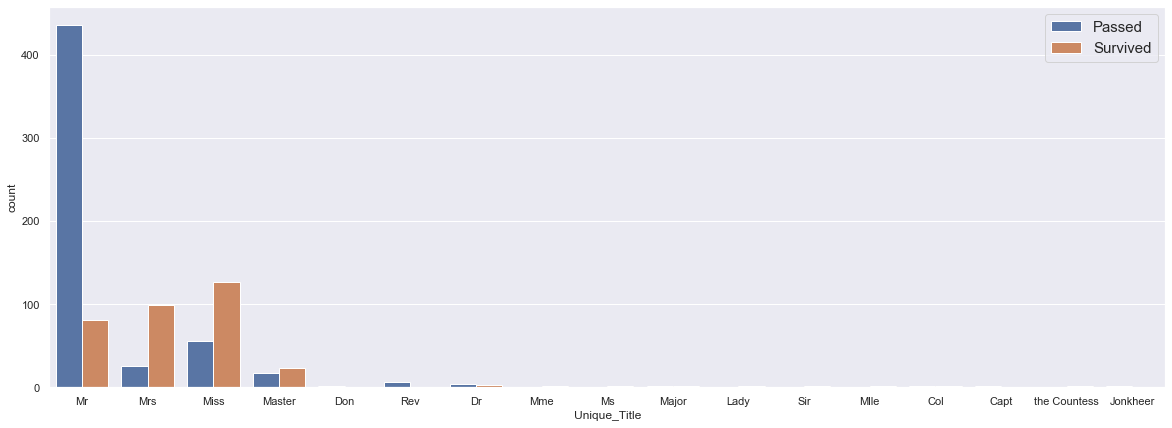

In [4]:
#Extracting the prefix from the entire name - ex: Mr, Mrs, Capt, etc.
train_data['Unique_Title'] = train_data['Name'].apply(lambda full_name: full_name.split(', ')[1].split('.')[0])
test_data['Unique_Title'] = test_data['Name'].apply(lambda full_name: full_name.split(', ')[1].split('.')[0])

#Plotting survival rate for each title
plt.figure(figsize=(20,7))
sns.countplot('Unique_Title',data=train_data, hue='Survived')
plt.legend(['Passed','Survived'], loc='upper right', prop={'size':15})

**Observations**
* The most significant titles are Mr, Mrs, Miss and Master.
* Mrs has the highest survival rate amongst all titles corresponding to women. 
* In most categories females have a higher survival rate than males.
* The title Master, which are males under the age of 26, have an extremely high survival rate compared to other males.
* The title Rev likely has the lowest survival rate amongst all titles.
* Many of the job title prefixes do not have a significant amount of data.


**Comments**<br>
* Based on the observations from the graph, there is a reasonable to way to lower the cardinality of the feature `Title` while preserving the general trends observed in the data.
  * Titles corresponding to men and women will be seperate - their survival rates are significantly different and this trend must be preserved.
  * The title Master has the highest survival rate for any title corresponding to a man, this title must be made into its own category to capture this trend.
  * The titles based on jobs will be the last category as they don't fit well into the male, female or master categories.
  * By grouping into these 4 categories, the cardinality of the feature `Title` has been significantly lowered while capturing as much information as possible.
* Due to the fact married women have the highest survival rate, it may be useful to create a boolean feature, `Married`, to indicate if a woman is married

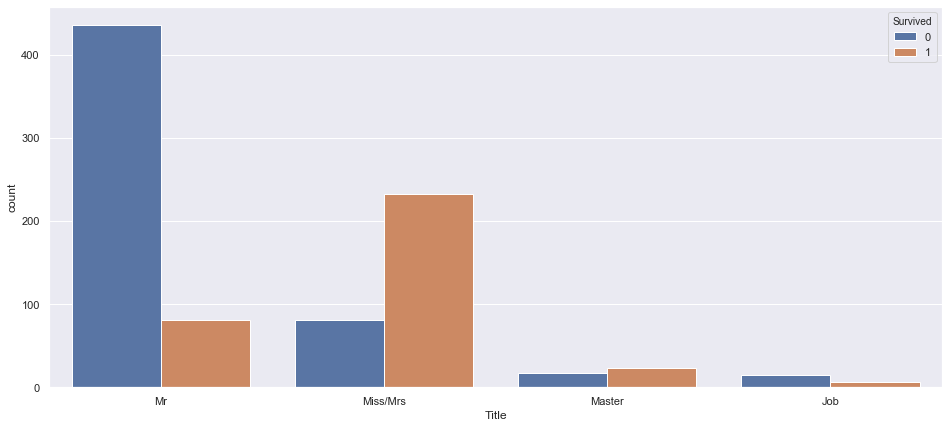

In [5]:
#Grouping the 17 unique titles into the 4 categories - Mr, Miss/Mrs, Job, Master
#Titles Mr and Master don't need to be touched because they are their own category
train_data['Title'] = train_data['Unique_Title']
train_data['Title'] = train_data['Title'].replace(['Dr','Col','Major','Jonkheer','Capt','Sir','Don','Rev'], 'Job')
train_data['Title'] = train_data['Title'].replace(['Miss','Mrs','Ms','Mlle','Lady','Mme','the Countess','Dona'], 'Miss/Mrs')
test_data['Title'] = test_data['Unique_Title']
test_data['Title'] = test_data['Title'].replace(['Dr','Col','Major','Jonkheer','Capt','Sir','Don','Rev'], 'Job')
test_data['Title'] = test_data['Title'].replace(['Miss','Mrs','Ms','Mlle','Lady','Mme','the Countess','Dona'], 'Miss/Mrs')

#Plotting 4 categories 
plt.figure(figsize=(16,7))
sns.countplot('Title', data=train_data, hue = 'Survived')

The results turned out great, the cardinality of this feature has significantly decreased and it captures important trends amongst different titles. Now let's create the feature `Married`.

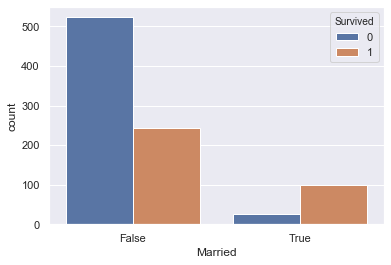

In [6]:
#Creating boolean feature Married
train_data['Married'] = train_data['Unique_Title']=='Mrs'
test_data['Married'] = test_data['Unique_Title']=='Mrs'

#Plotting new feature married
sns.countplot('Married', data=train_data, hue='Survived')

#Dropping columns that are not needed anymore - Name, Unique_Title
train_data.drop(['Name', 'Unique_Title'], axis=1, inplace=True)
test_data.drop(['Name', 'Unique_Title'], axis=1, inplace=True)

This would have been a more useful feature if it were possible to distinguish which men were married as well, however it still may add value to the model.

## 2.2 - `Fam_Size`
A new feature called `Fam_Size` is extracted from the original features `SibSp` and `Parch`. `Fam_Size` will be created in the following manner:

`Fam_Size` = `SibSp` + `Parch` 

The new feature will include different sizes of families starting from individual passengers to large sized families. These categories are defined in the following way.

* Individual:  0 family members
* Small Family:  1 to 2 family members
* Medium Family:  3 to 5 family members
* Large Family:  6+ family members

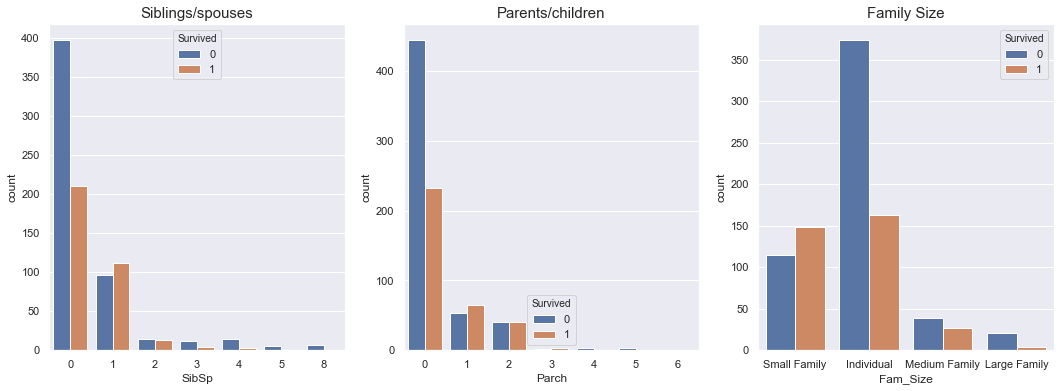

In [7]:
#Plotting SibSP and Parch to see distribution of target
fig, axs = plt.subplots(ncols = 3, nrows = 1,figsize=(18,6))
axs[0].set_title('Siblings/spouses', size=15)
axs[1].set_title('Parents/children', size=15)
sns.countplot('SibSp', data = train_data, ax=axs[0], hue='Survived')
sns.countplot('Parch', data = train_data, ax=axs[1], hue='Survived')

#Adding SibSp and Parch to create Fam_Size
train_data['Fam_Size'] = train_data['SibSp'] + train_data['Parch']
test_data['Fam_Size'] = test_data['SibSp'] + test_data['Parch']

#Making function to bin family sizes
def grouping(fam_size):
    if fam_size == 0:
        return 'Individual'
    elif 1 <= fam_size <= 2:
        return 'Small Family'
    elif 3 <= fam_size <= 5:
        return 'Medium Family'
    else:
        return 'Large Family'

#Applying grouping function to Fam_Size
train_data['Fam_Size'] = train_data['Fam_Size'].apply(grouping)
test_data['Fam_Size'] = test_data['Fam_Size'].apply(grouping)

#Plotting new feature Fam_Size
axs[2].set_title('Family Size', size=15)
sns.countplot('Fam_Size', data=train_data, hue='Survived', ax=axs[2])

#Dropping Parch and SibSp
train_data.drop(['SibSp','Parch'], axis=1, inplace=True)
test_data.drop(['SibSp','Parch'], axis=1, inplace=True)

The results turned out great, the new feature `Fam_Size` manages to capture the same trends that are present in the features `SibSp` and `Parch`.
* Individuals have a much lower survival rate
* Small to medium families had a higher survival rate
* Larger families seem to have a lower survival rate as well.

# 3 - Preprocessing 
This section will cover a series of preprocessing steps - handling missing data, converting categorical data into machine readable data. A very common technique used to convert categorical data is one hot encoding. One hot encoding creates a binary column for each category of a specific feature which indicates if the category is active. This is why it is important to lower the cardinality of the categorical features, if possible. The number of columns created is equal to the cardinality of the feature, this means with a high cardinality the number of columns dataset is being increased dramatically. This would significantly slow down processing times for the machine learning algorithms.

## 3.1 - Handling Missing Data
It was discovered in section 1.1 - dataset overview - that the training set and test set both have missing data. <br>
The training set has missing data from the following columns - `Age`, `Column` and `Embarked`.<br>
The test set has missing data from the following columns - `Age`, `Column` and `Fare`.<br>
The techniques used to fill the missing data are based off descriptive statistics of the features.

### 3.1.1 - `Age` Missing Data
Approximately 20% of the data points are missing the feature `Age`. Socioeconemic status will be used to aid in filling the missing data because `Pclass` and `Age` were highly correlated. A robust measure, the median, will be used to fill in the missing age for men and women of each socioeconomic class. To be as accurate as possible the feature `Sex` will also be considered while using the median.

This method for filling data will capture the trend that younger passengers generally have a lower socioeconomic status while also considering the age difference in the sexes. 

In [8]:
#Displaying the median for each class while considering sex 
all_data.groupby(['Pclass', 'Sex'])['Age'].median()

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64

In [9]:
#Filling the missing age datapoints with the median for each class while considering sex
#Using the population data to fill the missing data because it will give the most accurate representation for age
all_data['Age'] = all_data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda age: age.fillna(age.median()))

#Now move data from combined dataframe to training and test datasets.
train_data['Age'] = all_data.iloc[0:891]['Age']
test_data['Age'] = all_data.iloc[891:]['Age']

### 3.1.2 - `Embarked` Missing Data
There are 2 missing values from `Embarked` in the training dataset. They are both women who have the same ticketnumber, reside in the same cabin and are both first class passengers. This means they came together, however there is no way to know which port they left from. The best way to estimate which port they departed is to use the most frequent occurance for female passengers in first class, aka the mode.

In [10]:
#Finding the specific two passengers who are missing from embarked
train_data[train_data['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Married,Fam_Size
61,1,1,female,38.0,113572,80.0,B28,NaN,Miss/Mrs,False,Individual
829,1,1,female,62.0,113572,80.0,B28,NaN,Miss/Mrs,True,Individual


In [11]:
#Finding the most frequent port women in first class embarked from (use all the data to get accurate representation)
embarked_mode = all_data[(all_data['Sex']=='female') & all_data['Pclass']==1]['Embarked'].value_counts().index[0]

#Filling the missing values
train_data['Embarked'] = train_data['Embarked'].fillna(embarked_mode)

#Features Cabin and Ticket have not been dropped yet because they helped find information about the missing embarked data
#They completed their purpose and may now be dropped
train_data.drop(['Cabin', 'Ticket'], axis=1, inplace=True)
test_data.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

### 3.1.3 - `Fare` Missing Data
There is only 1 missing data point from `Fare` in the test dataset, the passenger is a 60 year old male who is 3rd class and embarked from South Hampton. `Fare` was most highly correlated to `Pclass`, therefore it is reasonable to use the median of ticket prices for people who are in 3rd class.

In [12]:
#Displaying the missing fare data point
test_data[test_data['Fare'].isnull()]

,Pclass,Sex,Age,Fare,Embarked,Title,Married,Fam_Size
152,3,male,60.5,NaN,S,Mr,False,Individual


In [13]:
#Finding the median for fare, only considering passengers in 3rd class
class3_fare_median = all_data[all_data['Pclass']==3]['Fare'].median()

#Filling the missing data point with the median
test_data['Fare'] = test_data['Fare'].fillna(class3_fare_median)

## 3.2 - One Hot Encoded Categorical Data
There are multiple categorical features that need to be one hot encoded including `Sex`, `Embarked`, `Title`,`Married` and `Fam_Size`. The other categorical feature `Pclass` is ordinal - there is no need to transform it. Ordinal data means there is a natural ordering to the categorical data.

In [14]:
#Define the categories that need to be onehotencoded
one_hot_feat = ['Sex', 'Embarked', 'Title', 'Married', 'Fam_Size']

#Use pandas get_dummies to onehot encode the features for training/test sets
#drop_first is on to eliminate multicollinearity
OH_features_train = pd.get_dummies(train_data[one_hot_feat], drop_first=True)
OH_features_test = pd.get_dummies(test_data[one_hot_feat], drop_first=True)

#Concatenate onehot encoded features to training/test sets
train_data = pd.concat([train_data,OH_features_train],axis=1)
test_data = pd.concat([test_data,OH_features_test],axis=1)

#Drop the categorical features that are not one hot encoded
train_data.drop(one_hot_feat, axis=1, inplace = True)
test_data.drop(one_hot_feat, axis=1, inplace = True)

## 3.3 - Numerical Data
There are two numerical features that will be used `Age` and `Fare`. <br>
When dealing with numerical data, it is a common practice to implement some form of transformation to standardize the data. This is known as feature scaling. However, for the models being considered in this notebook, feature scaling is not needed. In fact, leaving the data in it's raw state will allow for a more interpretable analysis of the `logit` model in section 4 - modelling. 

When left in it's raw form it will be possible to answer questions such as: <br>
*What are the odds a passenger survives if the price of their ticket was 100 dollars compared to someone who paid 10 dollars?*

However, when modelling numerical data, feature scaling can help to highlight the variables which are important automatically. It does this by punishing lowering weights of the non-significant variables - thus their effect on the model approximates to 0. 


# 4 - Modelling
This section will cover three different models:
* Statsmodels `Logit`
* ScikitLearn's `RandomForestClassifier` 
* XGBoost's `XGBoostClassifier`.

Let's begin by creating the train/validation split used to assess the models.

In [15]:
#Defining X and y
X_train = train_data.drop('Survived',axis=1)
X_test = test_data
y = train_data['Survived']

#Defining the seed used for all random_state arguments
SEED=42

#Making arrays of the X and y dataframes - Used for cross-validation in ensemble models
X_train_np_array = X_train.values
y_np_array = y.values
X_test_np_array = X_test.values

#Creating train/test splits of the X and y dataframes - used for validation/predictions in the logit model
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y, test_size=0.2, random_state=SEED)

## 4.1 - `Logit`
Statsmodels is a Python library that can be used to create different statistical models and tests, such as the `Logit` model. The logit is derived from a logistic regression, which is used for binary classification. The logistic regression makes use of a sigmoid function that is responsible for calculating the probability of the target. The logit is simply an algebraic reoganization of the logistic model and it is done in a manner such that the regression is linear. 

log(*odds*) = linear model <br>
or<br>
log (P(X)/(1-P(X)) = Bo + B1X1 + ... +BpXp

Where..
* P(X) is the probability a passenger survives
* 1-P(X) is the probability a passenger does not survive
* Xo... Xp are features
* Bo... Bp are coefficients

### 4.1.1 - Fitting the `Logit` Model

In [16]:
#Statsmodels does not automatically add an intercept with their logit model - do this manually
logit_X_train_with_intercept = sm.add_constant(X_train_split)

#Fit the model to the training data
logit = sm.Logit(y_train_split, logit_X_train_with_intercept).fit()

#Statsmodels provides a nice summary of the model, with p-values
logit.summary()

Optimization terminated successfully.
         Current function value: 0.419306
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      700
Method:                           MLE   Df Model:                           11
Date:                Tue, 30 Jun 2020   Pseudo R-squ.:                  0.3669
Time:                        19:06:28   Log-Likelihood:                -298.55
converged:                       True   LL-Null:                       -471.54
Covariance Type:            nonrobust   LLR p-value:                 1.709e-67
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.8558        nan        nan        nan         nan         nan
Pclass                    -0.9518      0.173     -5.514      0.000      -1.290      -0.614
Age                       -0.0109      0.010     -1.107      0.268      -0.030       0.008
Fare                       0.0025      0.003      0.986      0.324      -0.003       0.008
Sex_male                  -0.7033        nan        nan        nan         nan         nan
Embarked_Q                -0.5080      0.449     -1.131      0.258      -1.388       0.372
Embarked_S                -0.5286      0.282     -1.876      0.061      -1.081       0.024
Title_Master               3.3101      0.860      3.848      0.000       1.624       4.996
Title_Miss/Mrs             2.5591        nan        nan        nan         nan         nan
Title_Mr                   0.0338      0.644      0.053      0.958      -1.228       1.296
Fam_Size_Large Family     -2.6263      0.712     -3.689      0.000      -4.022      -1.231
Fam_Size_Medium Family    -1.5735      0.411     -3.827      0.000      -2.379      -0.768
Fam_Size_Small Family     -0.2151      0.255     -0.844      0.399      -0.715       0.285
==========================================================================================
"""

**Comments**
* The logit model is significantly different than a null model - this is evident by observing two things. 
  * The log likelihood > LL-null
  * LLR p-value = 0.000 
* Some variables are statistically significant while others are not, to determine which features are relevent the hypothesis test is employed. 
  * The null hypothesis for each feature states that the feature does not affect the targets - aka coefficient = 0. The level of significance (alpha) being considered is.. *α = 0.05*.
  * This means that if *p-value < α* then the null hypothesis is rejected and the weights are considered significant to the model.
* With the summary statistics statsmodels provides you can make important insights about your data. Here is an example

**Ex - Insight from model** <br>
*What are the odds a passenger survives if the price of their ticket was 100 dollars compared to someone who paid 5 dollars?* <br>
Fare 1 = 100 <br>
Fare 2 = 5
* Assumptions:
  * The feature `Fare` is statistically significant: *p-value < α*
  * All other features are kept the same.<br>
  
General Model: log(odds) = 1.8558 + -0.9518x*Pclass* - 0.0109x*Age* + .... 

log(odds1) = 1.8558 + 0.0025x*Fare1*<br>
log(odds2) = 1.8558 + 0.0025x*Fare2* <br>


log(odds1)-log(odds2) = 0.0025 x *ΔFare*

odds1/odds2 = exp(0.0025 x *ΔFare*)

odds1 = 1.26 x odds2

Therefore the odds of survival are 26% higher for a passenger who paid 100 dollars than a passenger who paid 5 dollars.

### 4.1.2 - Validating the `Logit` Model
With the fit model, it is possible to make predictions using the validation data. After making predictions on the features of the validation data, it is possible to assess the predictions of the model using the known validation targets.

There are many different metrics for classification problems including accuracy, precision, recall, sensitivity, F1-score etc. However, the ROC curve and ROC-AUC score are the most important.

All of these metrics are based on the confusion matrix, which provides a summary of the models performance. It shows how many type 1 and type 2 errors the model made with its predictions and how many predictions were correct.<br>
Based on this information, all the metrics mentioned above can be calculated.

In [17]:
#Must add intercept to validation data before using logit model
logit_X_val_with_intercept = sm.add_constant(X_val_split)

#Calculating probabilities of survival for each passenger
logit_X_val_prob = logit.predict(logit_X_val_with_intercept)

#Make function to round probabilities to finalized answers. Cutoff point is: P(X) = 0.5.
def logistic(Column):
    if Column <= 0.5:
        return 0
    else: 
        return 1

#Apply function to get validation data predictions
logit_X_val_pred = logit_X_val_prob.apply(logistic)

Now that predictions have been made by the model, they must be assessed. Below there is a function that reports the confusion matrix, classification report, ROC_AUC Score and ROC Curve.

Confusion Matrix:
 [[91 14]
 [19 55]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179



AUC_Score:  0.8969


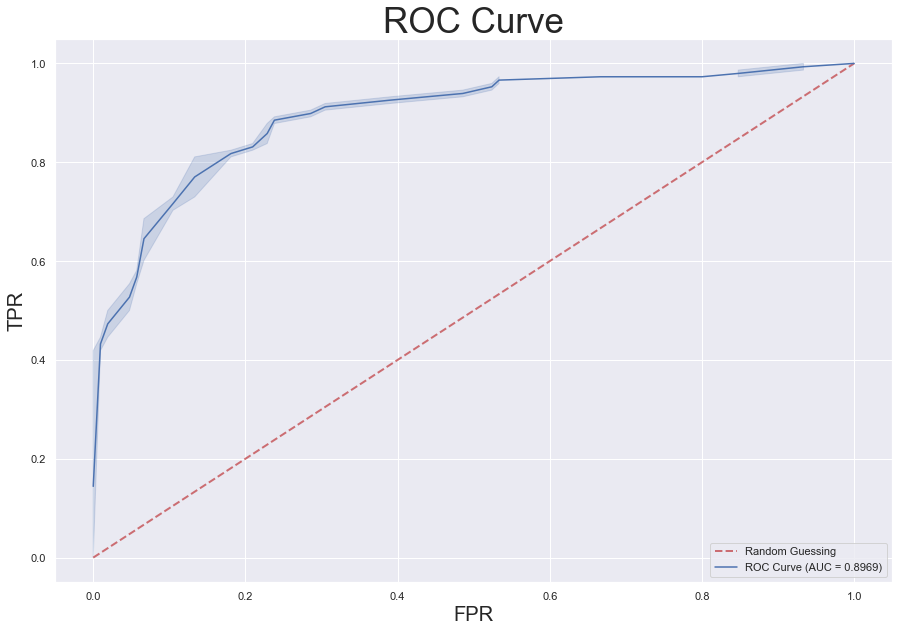

In [18]:
#Creating a function to report metrics for logit model
#Function will return confusion matrix, classification report, ROC curve and ROC-AUC Score
def metrics(model_target_probabilities, model_target_predictions):
    print('Confusion Matrix:\n', confusion_matrix(y_val_split, model_target_predictions))
    print('\nClassification Report:\n', classification_report(y_val_split, model_target_predictions))
        
    #Creating tpr and fpr for ROC curve
    false_pos_rates, true_pos_rates, thresholds = roc_curve(y_val_split, model_target_probabilities)
    
    #Calculating ROC_AUC score
    model_roc_auc_score = auc(false_pos_rates, true_pos_rates).round(4)
    print("\n\nAUC_Score: ", model_roc_auc_score)
    
    
    #Plotting ROC Curve
    plt.figure(figsize=(15,10))
    plt.ylabel('TPR', size=20)
    plt.xlabel('FPR', size=20)
    plt.title('ROC Curve', size = 35)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    sns.lineplot(x=false_pos_rates,y=true_pos_rates, label=f'ROC Curve (AUC = {model_roc_auc_score})')
    plt.legend(loc='lower right')
    
metrics(logit_X_val_prob, logit_X_val_pred)

### 4.1.4 - Competition Submission
This code is provided for anyone who would like to make a submission with the logit model - it achieved a score of 0.77511.

In [19]:
#Make predictions for submission - add intercept to test data
logit_test_with_intercept = sm.add_constant(X_test)
logit_test_prob = logit.predict(logit_test_with_intercept)
logit_test_pred = pd.DataFrame(logit_test_prob.apply(logistic))

#Save predictions into a CSV that can be uploaded to kaggle
logit_entry = pd.concat([test_PassengerID,logit_test_pred],axis=1)
logit_entry.columns = ['PassengerId', 'Survived']
logit_entry = logit_entry.set_index('PassengerId')
logit_entry.to_csv('Logit Entry')

## 4.2 - `RandomForestClassifier`
RandomForest's are ensemble models, this means they are comprised of many "weak learners" or base models (Ex: Decision Tree). Scikit learn's `RandomForestClassifier` uses a technique called bagging. Bagging uses the bootstrap technique (random sampling with replacement) to train L weak learners. These weak learners can be trained in parallel (at the same time). Then the ensemble aggregates the results from the L weak learners in a specific way to produce a prediction. Depending on the type of problem at hand (regression or classification) there are different methods for aggregating the weak learner predictions to get the ensemble prediction. 
* For regression a common method is to use a simple average of the loss functions (error in each weak learner)
* For classification there are 2 common ways to aggregate soft vote and hard vote.

There are many parameters to be considered when working with sklearn's `RandomForestClassifier`. Therefore, hyperparameter tuning must be implemented to create an ensemble that will produce more accurate predictions. To do this, use sklearn's `RandomizedSearchCV` object to iterate through different possible combinations of hyperparameters - we define the range for each parameter. During each iteration it uses training data to create predictions for the current hyperparameters and compares them to the target. It then returns the hyperparameters that performed the best. It does not iterate through every possible combination, the number of iterations is specified to save time. This object is meant to identify a hyper parameter values that make the model perform well, but the parameters can be optimized further.

After using sklearn's `RandomizedSearchCV` to find hyperparameters that perform well, there is another sklearn object that can be used to further tune hyperparmaters. The object `GridSearchCV` can be used to evaluate ALL possible combinations the model is provided. A range of values is created around the values obtained from the random search. The new range of values will be placed in the grid search object to test all possible combinations. At the end of the process, the hyperparameters will be optimized. 


### 4.2.1 - Fitting the RandomForest Model & Tuning Hyperparameters
Here is a quick overview of the hyperparamters that are being optimized. Note that all the hyperparameters that are being optimized are for the weak learners, none of the hyperparameters are modifying the ensemble - excluding n_est.
* **n_est**: the number of weak learners in the ensemble (decision trees)
* **max_features**: The number of features to consider when looking for the best split in a decision node
* **max_depth**: Is the depth of the decision tree (length of longest path from root to leaf)
* **min_samples_split**: The minimum number of samples required to split a node
* **min_samples_leaf**: The minimum numer of samples required at each leaf node

In [20]:
#Define a range of values for all the hyperparameters being optimized
n_est = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 20, num = 10)]
max_depth.append(None)  #Manually add no limit for tree depth - this is standard input
min_samples_split = [2,4,6,8]
min_samples_leaf = [1,2,3]

#Create the random grid by creating a dictionary of the inputs.
rf_param_grid = {'n_estimators':n_est,
                'max_features':max_features,
                'max_depth':max_depth,
                'min_samples_split':min_samples_split,
                'min_samples_leaf':min_samples_leaf}

#Create the model
rf = RandomForestClassifier()

Now that the hyper parameters have been defined in a grid and the model has been created, the RandomizedSearchCV object must be instantiated with the model and the parameter grid.

**Don't run the cell below - it may take a while to complete running.** 

After running the random search object, the best parameters were determined to be: <br>
{'max_depth': 17, <br>
 'max_features': 'sqrt', <br>
 'min_samples_leaf': 3, <br>
 'min_samples_split': 6, <br>
 'n_estimators': 500}

In [ ]:
#Instantiate RandomizedSearchCV object
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid,
                               n_iter=200, cv=3, verbose=2, random_state=SEED, n_jobs=-1)

#Fit the data to the object and perform search
rf_random.fit(X_train,y)

#Best parameters
rf_best_parameters = rf_random.best_params_
print('Best parameters:\n', rf_best_parameters)

Now that suboptimal parameters have been found with the `RandomizedSearchCV` object, the optimal parameters can be found using the `GridSearchCV` object. Again, the grid search must be instantiated with a base model and grid paramaters. The cell below does this.

**Don't run the cell below - it will take a while to complete running.** 

After running the grid search object, the best parameters were determined to be: <br>
{'max_depth': 17, <br>
 'max_features': 'auto', <br>
 'min_samples_leaf': 3, <br>
 'min_samples_split': 7, <br>
 'n_estimators': 353}

In [ ]:
#Define a range of values for all the hyperparameters being optimized
n_est = [int(x) for x in np.linspace(start = 300, stop = 700, num = 16)]  #Intervals of 25
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(15, 25, num = 10)]  
max_depth.append(None)  #Manually add no limit for tree depth - this is standard input
min_samples_split = [5,6,7]
min_samples_leaf = [2,3,4]

#Create the random grid by creating a dictionary of the inputs.
rf_param_grid = {'n_estimators':n_est,
                'max_features':max_features,
                'max_depth':max_depth,
                'min_samples_split':min_samples_split,
                'min_samples_leaf':min_samples_leaf}


#Create the model
rf = RandomForestClassifier()


#Instantiate GriddSearchCV object
rf_random = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, verbose=2, n_jobs=-1)

#Fit the data to the gridsearch object and perform search
rf_random.fit(X_train,y)

#Best parameters
rf_best_parameters = rf_random.best_params_
print('Best parameters:\n', rf_best_parameters)

Now that the optimal parameters have been found, use them in the `RandomForestClassifier`.

The best parameters were determined to be: <br>
{'max_depth': 17, <br>
 'max_features': 'auto', <br>
 'min_samples_leaf': 3, <br>
 'min_samples_split': 7, <br>
 'n_estimators': 353}

In [21]:
#Create the model with the optimized variables
rf = RandomForestClassifier(n_estimators=353, max_depth=17, max_features='auto', 
                            min_samples_leaf=3, min_samples_split=7,random_state=SEED)

#Fit the model to the training data and get validation predictions/probability which are used for classification metrics
rf.fit(X_train_split, y_train_split)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=353,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### 4.2.2 - Cross-Validation of the RandomForest Model
The metric that will be used to assess the `RandomForestClassifier` is the ROC score. However, because this is a relatively small amount of data cross-validation will be employed. Cross-validation is a technique used to train models when there is not enough data to perform a MEANINGFUL train/validation/test split.

A **general description** of cross validation: <br>
The data used to train the model is split into N chunks/splits and subsequently there are also N experiments that must be performed. For each experiment, one of the chunks/splits will be used as the validation set until all the chunks have been used as the validation set. The scores from each validation set are then used to assess the models performance.<br>

For example: <br>
If N = 5, the data is split 5 ways where each split accounts for 20% of the total training data, In experiment 1, the first split will be used as the validation data (which is used to make predictions and assess the models accuracy/ROC score etc.). In experiment 2, the second split will be used as the validation set and this continues for N iterations. <br>
At the end of this process, there are N sets of results and these results can be used to assess the performance of the model - average, std. dev., etc..
**There are many ways to split the data for the N splits - the general premise remains the same.**

**NOTE** <br>
* The data should be randomly shuffled before making the splits - thus insuring the data is independent. In this case, it is handled by the `RandomForestClassifier` object.
* The model is trained on ALL of the training data and validation data - just at different points. This may lead to overfitting, so if there is an abundance of data this method should be avoided.

Sci-kit learn does provide a bunch of objects that can be used for cross-validation, the one that is used below is the `StratifiedKFold` object. To use this object, the data must be put into a numpy array.

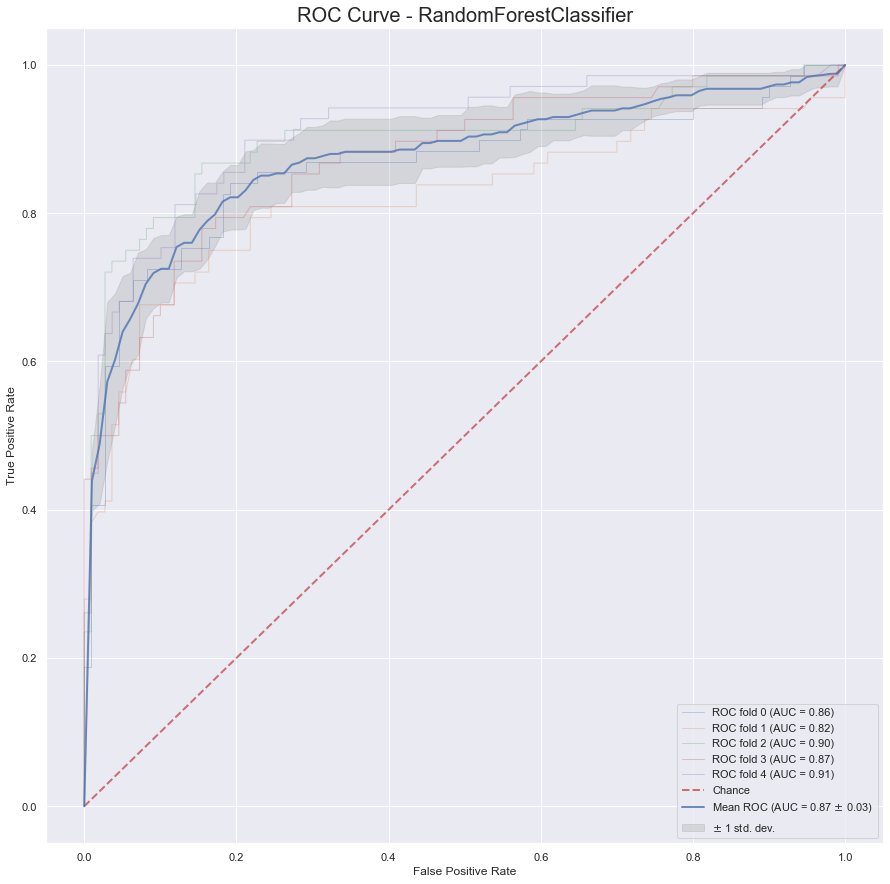

In [22]:
#Creating a function that crossvalidates data for a model and reports ROC Curve
#Function takes the following as arguments: number of splits for cv, model optimized w/ h.param., modelname (for title of ROC_curve)
def cv_roc_score(num_of_splits, model, title):

    #First define the cross-validation object and the model
    cv = StratifiedKFold(n_splits=num_of_splits)
    classifier = model

    #Next create place holders for the true positive rates and AUC scores for each experiment/split
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)


    #Creating plot and iterating to find tpr and AUC score for each split
    fig, ax = plt.subplots(figsize=(15,15))
    for i, (train, test) in enumerate(cv.split(X_train_np_array, y_np_array)):
        classifier.fit(X_train_np_array[train], y_np_array[train])
        viz = plot_roc_curve(classifier, X_train_np_array[test], y_np_array[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    #Plotting line that represents ROC curve if random guessing were implemented 
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    #Creating the ROC curves, mean AUC score and standard deviation of the AUC score
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    #Creating grey space for standard deviation of ROC curve
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')


    #Setting axis limits, title and legend
    ax.set_xlim([-0.05,1.05])
    ax.set_ylim([-0.05,1.05])
    ax.set_title(f"ROC Curve - {title}", fontsize=20)
    ax.legend(loc="lower right")

    
    
#Defining paramters for cv_roc_score function
num_splits = 5
title = 'RandomForestClassifier'
rf_classifier = RandomForestClassifier(n_estimators=353, max_depth=17, max_features='auto', 
                                min_samples_leaf=3, min_samples_split=7,random_state=SEED)

#Implementing cv_roc_score function
cv_roc_score(num_of_splits=num_splits, model=rf_classifier, title=title)

### 4.2.3 - Predictions with the RandomForest Model
Cross-validation technique will be implemented again to create predictions for the test dataset & submission. The strategy is to train the model using the same cross-validation split for consistency but calculate target probabilities instead of calculating metrics to assess the models performance. Target probabilities will be calculated **for every** split and then averaged out over N splits. 

**The resulting cross-validation predictions will be based on the average target probabilities of the N splits.**

In [33]:
#Make a function that creates cross-validation predictions
#The function will take 2 arguments: the number of splits used in cross-validation, the model
#Function will return predictions as a dataframe 
def cv_pred(num_of_splits, model):
    #Creating a dataframe to store the probabilities from each split
    cv_prob_np_array = np.zeros(shape=(X_test.shape[0],num_of_splits))
    cv_prob = pd.DataFrame(cv_prob_np_array, columns=[f'Fold_{split}' for split in range(num_of_splits)])
    
    #First define the cross-validation object and the model
    cv = StratifiedKFold(n_splits=num_of_splits)
    classifier = model
    
    for split, (train, test) in enumerate(cv.split(X_train_np_array, y_np_array)):
        classifier.fit(X_train_np_array[train], y_np_array[train])
        cv_prob.loc[:,f'Fold_{split}'] = classifier.predict_proba(X_test)[:,1]
    
    avg_prob = cv_prob.mean(axis=1)
    
    #Create function to round probabilities into predictions
    def predictions(Column):
        if Column <= 0.5:
            return 0
        else: 
            return 1
    
    #Use function to make predictions
    final_predictions = avg_prob.apply(predictions)
    
    return final_predictions



#Defining paramters for cv_pred function
num_splits = 5
title = 'RandomForestClassifier'
rf_classifier = RandomForestClassifier(n_estimators=353, max_depth=17, max_features='auto', 
                                min_samples_leaf=3, min_samples_split=7,random_state=SEED)

#Implementing cv_pred function
rf_predictions = cv_pred(num_of_splits=num_splits, model=rf_classifier)

### 4.2.4 - Competition Submission
This code is provided for anyone who would like to make a submission with the random forest model - it achieved a score of 0.79425.

In [34]:
#Gathering and cleaning data for submission
rf_entry = pd.concat([test_PassengerID, rf_predictions],axis=1)
rf_entry.columns = ['PassengerId', 'Survived']
rf_entry = rf_entry.set_index('PassengerId')
rf_entry.to_csv('Random Forest Entry')

## 4.3 - `XGBClassifier`
XGB stands for extreme gradient boosting, this is another type of ensemble model. Gradient boosting uses weak learners like the bagging technique does. However, the weak learners are fit in a different manner - it is an iterative process. Training/fitting begins by initializing a single weak learner, after this point the iterative cycle continues until all weak learners have been fit to create the ensemble. 
* Step 1: Fit the first weak learner - after this the iterative cycle begins.
* Step 2: Use the current ensemble to generate predictions for each observation in the dataset. The prediction of the current ensemble comes from predictions of ALL weak learners that have been trained. 
* Step 3: Use predictions to calculate loss function (Error function used to assess the model)
* Step 4: Use gradient descent on loss function to determine parameters of the new model. These new parameters are used to fit the new model
* Step 5: Add the new model to ensemble
* Step 6: Repeat until completed


### 4.3.1 - Fitting the Model
The process for fitting the XGBClassifier will be similar to fitting the random forest model, there are hyperparameters that need to be optimized before the model will perform well. To tune the hyperparameters the same methods will be implemented which entail the following.
* General search for range of optimal hyperparameters using `RandomizedSearchCV`
* Intensive search using `GridSearchCV`, which checks every possible combination to find optimal hyperparameters based on previous search.

Here is a quick overview of the hyperparameters being optimized. Note that some parameters are optimizing the weak learners, while others are optimizing the aggregation portion of the ensemble.
* **eta**: #Learning rate - makes model more robust by shrinking weights on each step
* **n_est**: the number of weak learners in the ensemble (decision trees)
* **max_depth**: Is the depth of the decision tree (length of longest path from root to leaf)
* **min_child_weight**: Minimum sum of instance weight(hessian) needed in a child 
* **gamma**: #Minimum loss reduction required to make a further partition on a leaf node of the tree.

**Don't run the cell below - it will take a while to complete running.** 

The best parameters were determined to be: <br>
{'n_estimators': 1000,<br>
 'min_child_weight': 5,<br>
 'max_depth': 6,<br>
 'learning_rate': 0.25,<br>
 'gamma': 0.3}

In [ ]:
#Define a range of values for all the hyperparameters being optimized
eta = [0.05,0.1,0.15,0.2,0.25]
n_est = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 18)] #Increments of 50
max_depth = [int(x) for x in range(1,11)]
max_depth.append(None)  #Manually add no limit - this is standard input
min_child_weight = [int(x) for x in range(1,6,2)]
gamma = [x/10.0 for x in range(0,5)]

#Create the random grid by creating a dictionary of the inputs.
xgb_param_grid = {'learning_rate':eta,
                'n_estimators':n_est,
                'max_depth':max_depth,
                'min_child_weight':min_child_weight,
                'gamma':gamma}


#Create the model
xgb = XGBClassifier()


#Instantiate RandomizedSearchCV object with model and parameters
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_grid,
                               n_iter=200, cv=3, verbose=2, random_state=SEED, n_jobs=-1)

#Fit the data to the object and perform search
xgb_random.fit(X_train,y)

#Best parameters
xgb_best_parameters = xgb_random.best_params_
print('Best parameters:\n', xgb_best_parameters)

Now that suboptimal parameters have been found with the `RandomizedSearchCV` object, the `GridSearchCV` object will be used to find optimized hyperparameters. Again, the grid search must be instantiated with a base model and grid paramaters. The cell below does this.

**Don't run the cell below - it will take a while to complete running.** 

The best parameters were determined to be: <br>
{'n_estimators': 700,<br>
 'min_child_weight': 3,<br>
 'max_depth': 6,<br>
 'learning_rate': 0.25,<br>
 'gamma': 0.4}

In [ ]:
#Define a range of values for all the hyperparameters being optimized
eta = [0.1,0.15,0.2,0.25,0.3]
n_est = [int(x) for x in np.linspace(start = 700, stop = 1300, num = 12)] #Increments of 50
max_depth = [int(x) for x in np.linspace(start=3, stop=9, num=6)]
max_depth.append(None)  #Manually add no limit - this is standard input
min_child_weight = [int(x) for x in range(3,7,4)]
gamma = [x/10.0 for x in range(1,5)]

#Create the random grid by creating a dictionary of the inputs.
xgb_param_grid = {'learning_rate':eta,
                'n_estimators':n_est,
                'max_depth':max_depth,
                'min_child_weight':min_child_weight,
                'gamma':gamma}

#Create the model
xgb = XGBClassifier()


#Instantiate GriddSearchCV object
xgb_random = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=3, verbose=2, n_jobs=-1)

#Fit the data to the object and perform search
xgb_random.fit(X_train,y)

#Best parameters
xgb_best_parameters = xgb_random.best_params_
print('Best parameters:\n', xgb_best_parameters)

Now that the optimal parameters have been found, use them in the `XGBoostClassifier`.

The best parameters were determined to be: <br>
{'n_estimators': 700,<br>
 'min_child_weight': 3,<br>
 'max_depth': 6,<br>
 'learning_rate': 0.25,<br>
 'gamma': 0.4}

### 4.3.2 Cross-Validation of XGBClassifier
The same method used to cross-validate the random forest ensemble will be used for the `XGBClassifier`. The cv_roc_score function used before will now be implemented. It requires 3 parameters - the number of splits for cv, the model and the title for the curve.

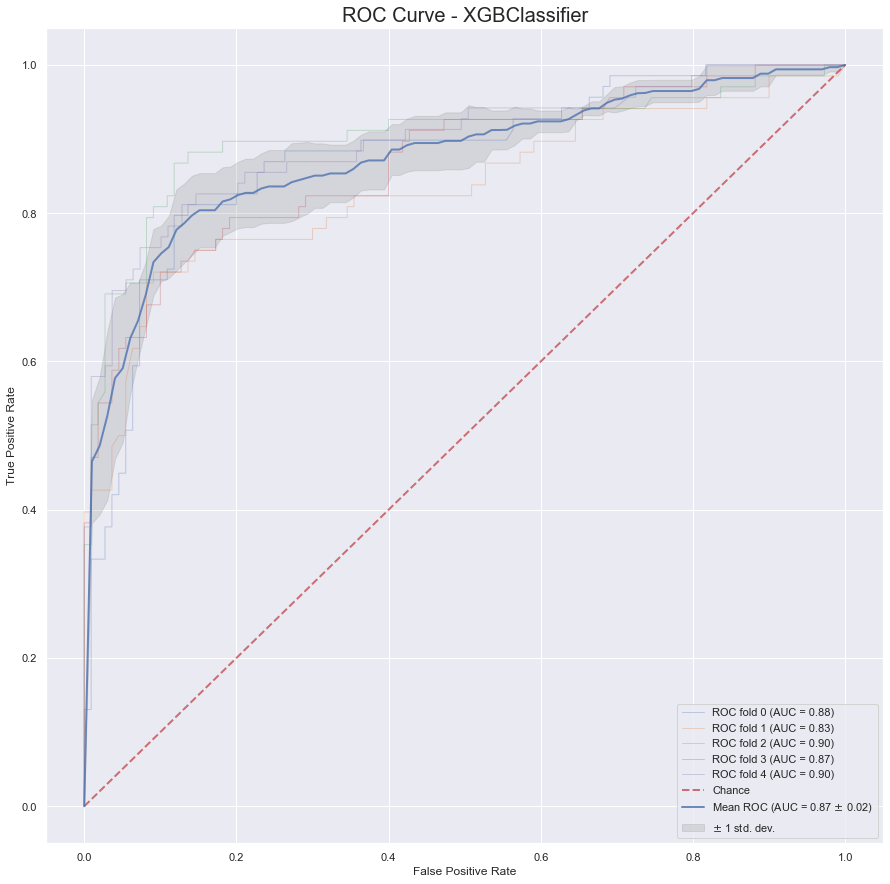

In [35]:
#Defining paramters for cv_roc_score function
num_splits = 5
title = 'XGBClassifier'
xgb_classifier = XGBClassifier(n_estimators=700, max_depth=6, gamma=0.4, eta=0.25, min_child_weight=3, random_state=SEED)

#Implementing cv_roc_score function
cv_roc_score(num_of_splits=num_splits, model=xgb_classifier, title=title)

### 4.3.3 - Predictions with XGBClassifier
The same function used to predict with the `RandomForestClassifier` will be implemented here.

In [36]:
#Defining paramters for cv_pred function
num_splits = 5
xgb_classifier = XGBClassifier(n_estimators=700, max_depth=6, gamma=0.4, eta=0.25, min_child_weight=3, random_state=SEED)

#Implementing cv_pred function
rf_predictions = cv_pred(num_of_splits=num_splits, model=rf_classifier)

### 4.3.4 - Competition Submission
This code is provided for anyone who would like to make a submission with the extreme gradient boosting model - it achieved a score of .80382.

In [37]:
#Making predictions on test data
xgb_predictions = pd.DataFrame(rf.predict(X_test))

#Gathering and cleaning data for submission
xgb_entry = pd.concat([test_PassengerID, xgb_predictions],axis=1)
xgb_entry.columns = ['PassengerId', 'Survived']
xgb_entry = xgb_entry.set_index('PassengerId')
xgb_entry.to_csv('Extreme Gradient Boost Entry')

# 5 - Conclusion
If you made it this far, congratulations on finishing the notebook! I hope this helped you understand some new data science concepts. **Please upvote the notebook!! It would help me out alot!**

PS: If you have any notes or tips - please feel free to leave a comment or message me!